### **Mount Google Drive/Parent Directory**

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


### **Install and Import Libraries**

In [2]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import numpy as np                             
from numpy.linalg import inv                 
import matplotlib.pyplot as plt                 
from scipy.stats import multivariate_normal   

from google.colab.patches import cv2_imshow

from sklearn.metrics import jaccard_score
from sklearn.cluster import KMeans

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim

from tqdm import tqdm

**Image Slice Visualization**

In [ ]:
# Visualiza 2D Slice from 3D Image
def slice_show(image, slice_no):
    plt.figure()
    plt.axis('off')
    plt.imshow(image[:,:,slice_no].T, cmap='gray')

### **Evaluation Metric**

In [ ]:
def tissue_visualization(Seg_CSF, GT_CSF, Seg_GM, GT_GM, Seg_WM, GT_WM, number_of_slice):

  #Visualize each tissue separately
  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots( 2, 3, figsize=(10,6))

  ax1.set_title("Class CSF #{}".format(number_of_slice))
  img1 = ax1.imshow(np.transpose(Seg_CSF[:,:,number_of_slice]), cmap = "gray")
  ax2.set_title("Class GM #{}".format(number_of_slice))
  img2 = ax2.imshow(np.transpose(Seg_GM[:,:,number_of_slice]), cmap = "gray")
  ax3.set_title("Class WM #{}".format(number_of_slice))
  img3 = ax3.imshow(np.transpose(Seg_WM[:,:,30]), cmap = "gray")
  ax4.set_title("Ground Truth CSF #{}".format(number_of_slice))
  img4 = ax4.imshow(np.transpose(GT_CSF[:,:,number_of_slice]), cmap = "gray")
  ax5.set_title("Ground Truth of GM #{}".format(number_of_slice))
  img5 = ax5.imshow(np.transpose(GT_GM[:,:,number_of_slice]), cmap = "gray")
  ax6.set_title("Ground Truth of WM #{}".format(number_of_slice))
  img6 = ax6.imshow(np.transpose(GT_WM[:,:,number_of_slice]), cmap = "gray")
  

  ax1.axis('off')
  ax2.axis('off')
  ax3.axis('off')
  ax4.axis('off')
  ax5.axis('off')
  ax6.axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
def diceScoreSimilarity(segmented_image_nifi, ground_truth_nifti):
           
    # Compute DICE
    def dice(SI, GT):
        #   2 * TP / (FN + (2 * TP) + FP)
        intersection = np.logical_and(SI, GT)
        return 2. * intersection.sum() / (SI.sum() + GT.sum())
    
    # Dice  for CSF
    Seg_CSF = (segmented_image_nifi == 1)
    GT_CSF = (ground_truth_nifti == 1)
    dice_CSF = dice(Seg_CSF, GT_CSF)
    # Dice  for GM
    Seg_GM = (segmented_image_nifi == 2)
    GT_GM = (ground_truth_nifti == 2)
    dice_GM = dice(Seg_GM, GT_GM)
    # Dice  for WM
    Seg_WM = (segmented_image_nifi == 3)
    GT_WM = (ground_truth_nifti == 3)
    dice_WM = dice(Seg_WM, GT_WM)

    #  Visualiza each tissue class separately
    number_of_slice = 24
    tissue_visualization(Seg_CSF, GT_CSF, Seg_GM, GT_GM, Seg_WM, GT_WM, number_of_slice)

    return dice_CSF, dice_GM, dice_WM

### **NIFTI Image Read and Load**

In [ ]:
# Library to read .nii Images
!pip install nibabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import nibabel as nib

In [ ]:
# Choice of the Patient from 1 to 5
choice = 5
# Slice number for segmentation
n_slice = 24
# Read Nifti Images
input_directory = '/content/drive/MyDrive/Colab Notebooks/MISA-MIRA/P2_data'
patient = input_directory + '/' + str(choice)
# T1 weighted Image
t1_data = nib.load(patient + '/T1.nii')
t1_img = t1_data.get_fdata()
# T2 Flair weighted Image
t2flair_data = nib.load(patient +'/T2_FLAIR.nii')
t2flair_img= t2flair_data.get_fdata()
# Ground Truth
ground_data = nib.load(patient +'/LabelsForTesting.nii')
ground_truth = ground_data.get_fdata()
labeled_img = ground_truth.copy()

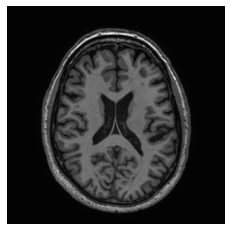

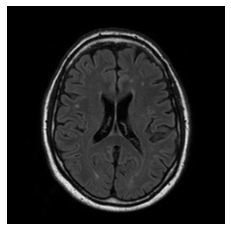

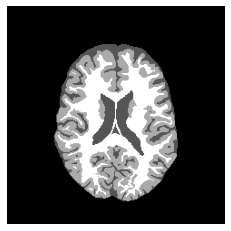

In [ ]:
# Visualize the input images and ground truth
slice_show(t1_img, n_slice)
slice_show(t2flair_img, n_slice)
slice_show(labeled_img, n_slice)

### **Skull Stripping**

In [ ]:
def skull_stripping(input_img, labeled_img):
  labeled_img[labeled_img>0]=1
  result = np.multiply(input_img, labeled_img)
  return result

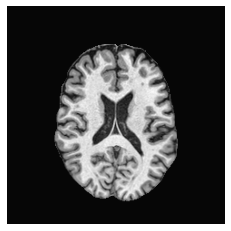

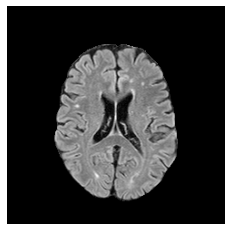

In [ ]:
# Visualize the input images after Skull Stripping 
brain_image_t1 = skull_stripping(t1_img, labeled_img)
brain_image_t2flair = skull_stripping(t2flair_img, labeled_img)

# Saving the images in Nifti Format
brain_image_t1_data = nib.Nifti1Image(brain_image_t1, t1_data.affine, t1_data.header)
brain_image_t1_nifti = brain_image_t1_data.get_fdata()
brain_image_t2flair_data = nib.Nifti1Image(brain_image_t2flair, t2flair_data.affine, t2flair_data.header)
brain_image_t2flair_nifti = brain_image_t2flair_data.get_fdata()

# Visualize the input images and ground truth
slice_show(brain_image_t1_nifti, n_slice)
slice_show(brain_image_t2flair_nifti, n_slice)

### **K-means Clustering**

In [ ]:
def KmeansInitialization(brain_image_t1_nifti, brain_image_t2flair_nifti):

    flatten_brain_image_t1 = brain_image_t1_nifti.copy().flatten()
    flatten_brain_image_t2flair = brain_image_t2flair_nifti.copy().flatten()
    feature_data = np.vstack((flatten_brain_image_t1, flatten_brain_image_t2flair))
    feature_data = np.transpose(feature_data)

    # Extracting black background from the image data considering only brain
    brain_indices = []
    for index, data in enumerate(feature_data):
      if data.any():
        brain_indices.append(index)

    # Brain Data excluding background pixels
    brain_data = feature_data[brain_indices]

    # K-means Clustering
    num_cluster = 3
    kmeans=KMeans(n_clusters = num_cluster,  init = 'k-means++', random_state = 0).fit(brain_data)
    Kmeans_predict = kmeans.predict(brain_data)
    centroids = kmeans.cluster_centers_

    # Sorting centroids using T1 weighted mean
    centroids_t1 = centroids[:,0]
    min_idx = np.argmin(centroids_t1, axis=0)
    max_idx = np.argmax(centroids_t1, axis=0)

    centroids_updated = np.zeros(centroids.shape)
    Kmeans_predict_updated = np.zeros(Kmeans_predict.shape)

    # Updating centroid after sorting according to mean values
    centroids_updated[0] = centroids[min_idx]
    centroids_updated[2] = centroids[max_idx]

    for i in [0,1,2]:
      if (min_idx != i and max_idx != i):
        mid_idx = i
        centroids_updated[1] = centroids[i]

    # Making the levels according to the ground truth (not starting from zero)
    Kmeans_predict_updated[Kmeans_predict==min_idx] = 1
    Kmeans_predict_updated[Kmeans_predict==mid_idx] = 2 
    Kmeans_predict_updated[Kmeans_predict==max_idx] = 3

    # Assigning classes to tissues
    CSF_tissue = brain_data[Kmeans_predict_updated == 1]
    GM_tissue = brain_data[Kmeans_predict_updated == 2]
    WM_tissue = brain_data[Kmeans_predict_updated == 3]

    # Computing mean and covariance
    mean_CSF = np.mean(CSF_tissue, axis = 0)
    mean_GM = np.mean(GM_tissue, axis = 0)
    mean_WM = np.mean(WM_tissue , axis = 0)
    cov_CSF = np.cov(CSF_tissue, rowvar = False)
    cov_GM = np.cov(GM_tissue, rowvar = False)
    cov_WM = np.cov(WM_tissue , rowvar = False)

    # Computing prior probabilities of each class
    pp_CSF = CSF_tissue.shape[0]/brain_data.shape[0]
    pp_GM = GM_tissue.shape[0]/brain_data.shape[0]
    pp_WM = WM_tissue.shape[0]/brain_data.shape[0]

    # Clusteres Image Generation By Kmeans
    clustered_data_t1 =  np.zeros(feature_data.shape[0])
    # clustered_data_t2flair =  np.zeros(feature_data.shape[0])
    clustered_data_t1[brain_indices] = Kmeans_predict_updated
    # clustered_data_t2flair[brain_indices] = Kmeans_predict_updated
    clustered_img_t1 = np.reshape(clustered_data_t1, brain_image_t1_nifti.shape)
    # clustered_img_t2flair = np.reshape(clustered_data_t2flair, brain_image_t2flair_nifti.shape)
    clustered_img = clustered_img_t1.copy()

    return mean_CSF, mean_GM, mean_WM, cov_CSF, cov_GM, cov_WM, pp_CSF, pp_GM, pp_WM, clustered_img

### **WorkFlow**

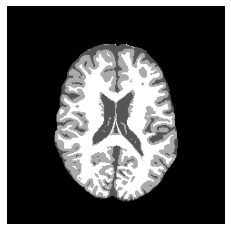

In [ ]:
# K-means Clustering Initialization
mean_CSF, mean_GM, mean_WM, cov_CSF, cov_GM, cov_WM, pp_CSF, pp_GM, pp_WM, clustered_img = KmeansInitialization(brain_image_t1_nifti, brain_image_t2flair_nifti)

# Saving the images in Nifti Format
brain_seg_data = nib.Nifti1Image(clustered_img, t1_data.affine, t1_data.header)
brain_seg_nifti = brain_seg_data.get_fdata()
# brain_seg_t2flair_data = nib.Nifti1Image(clustered_img_t2flair, t2flair_data.affine, t2flair_data.header)
# brain_seg_t2flair_nifti = brain_seg_t2flair_data.get_fdata()

# Image Visualization after Kmeans Clustering
slice_show(brain_seg_nifti, 24)
# slice_show(brain_seg_t2flair_nifti, 24)

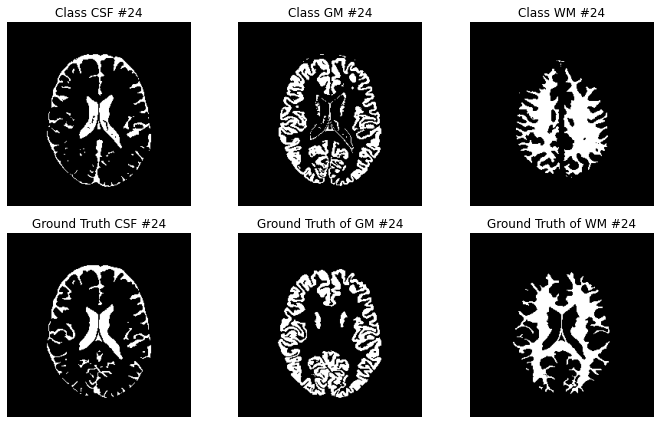

CSF DICE = 0.8569429725791495 GM DICE = 0.8007394351059713 WM DICE = 0.8441203221596826


In [ ]:
# Evaluation using DICE Score
dice_CSF, dice_GM, dice_WM = diceScoreSimilarity(brain_seg_nifti, ground_truth)
print("CSF DICE = {}".format(dice_CSF), "GM DICE = {}".format(dice_GM), "WM DICE = {}".format(dice_WM))

EM Algorithm

In [ ]:
# Mixture weights
a_csf= 1/3
a_gm= 1/3
a_wm= 1/3

In [ ]:
#Random Covariance generation
def random_covariance(a):
  x= np.random.normal(0,1,size=(a,a))
  return np.dot(x,x.transpose())

In [ ]:
#Random parameters initialization
def random_parameters():
  parameters={'mean_CSF': np.random.normal(0,1,size=(2,)), 'mean_GM': np.random.normal(0,1,size=(2,)), 'mean_WM': np.random.normal(0,1,size=(2,)),
              'cov_CSF': random_covariance(2), 'cov_GM': random_covariance(2), 'cov_WM': random_covariance(2)}
  return parameters

In [ ]:
init_parameters= random_parameters()


In [ ]:
def ExpectationStep(x,parameters):
  #Gaussian Mixture models
  
  p_csf= multivariate_normal.pdf(x, mean= init_parameters['mean_CSF'], cov= init_parameters['cov_CSF'])
  p_gm= multivariate_normal.pdf(x, mean= init_parameters['mean_GM'], cov= init_parameters['cov_GM'])
  p_wm= multivariate_normal.pdf(x, mean= init_parameters['mean_WM'],cov= init_parameters['cov_WM'])

  #Membership weights

  w_csf= (p_csf*a_csf)/((p_csf*a_csf)+(p_csf*a_csf)+(p_csf*a_csf))
  w_gm= (p_gm*a_gm)/((p_gm*a_gm)+(p_gm*a_gm)+(p_gm*a_gm))
  w_wm= (p_wm*a_wm)/((p_wm*a_wm)+(p_wm*a_wm)+(p_wm*a_wm))

  #MEMBERSHIP N X K - > N-> # total pixels, k -> #N clusters

  weights_vector= np.vstack((w_csf,w_gm, w_wm))
  weights_vector= np.transpose(weights_vector)

  #Computation of log likelihood

  loglikelihood= sum((np.log(sum(weights_vector))))

  return weights_vector, loglikelihood


In [ ]:
def MaximizationStep(x,parameters):

  #Calculation of Nk

  weights_vector,_ = ExpectationStep(x,parameters)
  N_0= sum(weights_vector[:,0])
  N_1= sum(weights_vector[:,1])
  N_2= sum(weights_vector[:,2])

  #Calculation of new mixture weights

  a_new_csf= N_0/x.shape[0]
  a_new_gm= N_1/x.shape[0]
  a_new_wm= N_2/x.shape[0]

  #Calculation of new parameters

  new_mean_csf= (1/N_0)*(weights_vector[:,0]) @ x
  new_mean_gm= (1/N_1)*(weights_vector[:,1]) @ x
  new_mean_wm= (1/N_2)*(weights_vector[:,2]) @ x

  new_cov_csf= (1/N_0)*(weights_vector[:,0]*np.transpose(x-new_mean_csf)) @ (x-new_mean_csf) 
  new_cov_gm= (1/N_1)*(weights_vector[:,1]*np.transpose(x-new_mean_gm)) @ (x-new_mean_gm) 
  new_cov_wm= (1/N_2)*(weights_vector[:,2]*np.transpose(x-new_mean_wm)) @ (x-new_mean_wm)


  new_parameters={'mean_CSF': new_mean_csf, 'mean_GM': new_mean_gm, 'mean_WM': new_mean_wm,
              'cov_CSF': new_cov_csf, 'cov_GM': new_cov_gm, 'cov_WM': new_cov_wm}


  return new_parameters

Iterations

In [ ]:
flatten_array=t1_img[labeled_img!=0]
x= flatten_array.reshape(flatten_array.shape[0],-1)

470229